In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy as sp
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf as pacf_func
from statsmodels.graphics.tsaplots import acf as acf_func
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsa

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

plt.style.use("ggplot")

import warnings

warnings.filterwarnings("ignore")

# <font face="gotham" color="purple"> AR Model </font>

Though the **Autoregressive model** rarely plays a role in practice, joined with **Moving Average model** they undoubted are the foundation of advanced techniques. Here is the standard form of $\text{AR(1)}$
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
If $\phi_1<1$, the series exhibits mean-reversion feature, and $\phi_1>1$ exhibits trend-following feature. 

As a reminder for ```statsmodels```, ```ArmaProcess``` object needs zero lag coefficient to be $1$ explicitly input and the signs from lag $1$ onward also must be reversed, e.g. plus sign reversed to minus.

## <font face="gotham" color="purple"> Features of AR </font>

We have shown that as long as the eigenvalues, all the $\lambda$'s of the AR system stay within unit modulus, the system will be stable.

Now take expectation of a stationary $\text{AR(1)}$
$$
E\left(Y_t\right)=\phi_0+\phi_1 \cdot E\left(Y_{t-1}\right)+E\left(u_t\right)\quad \longrightarrow \quad \mu=\phi_0+\phi_1 \cdot \mu \quad \longrightarrow \quad \mu= \frac{\phi_0}{1-\phi_1}
$$

To derive the variance of $\text{AR(1)}$, we need some extra work.

To simplify the derivation, we use a $\text{AR(1)}$ without a constant, then demean it

$$
\left(Y_t-\mu\right)=\phi\left(Y_{t-1}-\mu\right)+u_t\tag{1}\label{1}
$$

Take square, then expectation on both sides of $(1)$
$$
E\left(Y_t-\mu\right)^2=\phi^2 E\left(Y_{t-1}-\mu\right)^2+2 \phi E\left[\left(Y_{t-1}-\mu\right) u_t\right]+E\left(u_t^2\right)
$$

The second term $2 \phi E\left[\left(Y_{t-1}-\mu\right) u_t\right]$ will be $0$.

Assume $E\left(Y_t-\mu\right)^2=E\left(Y_{t-1}-\mu\right)^2=\gamma_0$, $\gamma_0$ represents autocovariance at $0$ lag, i.e. variance, therefore the expression tells the covariance stationarity.

We obtain the final expression of variance
$$
\gamma_0=\sigma^2 /\left(1-\phi^2\right)
$$

To derive a general expression of autocovaraince, multiply $\left(Y_{t-j}-\mu\right)$ on both sides of $(1)$

$$
\begin{aligned}
E\left[\left(Y_t-\mu\right)\left(Y_{t-j}-\mu\right)\right]=\phi\cdot E\left[\left(Y_{t-1}-\mu\right)\left(Y_{t-j}-\mu\right)\right]+E\left[\varepsilon_t\left(Y_{t-j}-\mu\right)\right]
\end{aligned}
$$

By assuming $E\left[\varepsilon_t\left(Y_{t-j}-\mu\right)\right]$, we obtain
$$
\gamma_j=\phi \gamma_{j-1}
$$

The solution of difference equation is
$$
\gamma_j=\phi^j \gamma_0 \longrightarrow \rho_{j} = \frac{\gamma_{j}}{\gamma_{0}} =\phi^j
$$

We have just shown that in $\text{AR(1)}$ model, dynamic multiplier equals autocorrelation!

As for $\text{AR}(p)$ model, similar results can be achieved, also start from a demeaned $\text{AR}(p)$.
$$
\begin{aligned}
Y_t-\mu=\phi_1\left(Y_{t-1}-\mu\right)+\phi_2\left(Y_{t-2}-\mu\right)+\cdots+\phi_p\left(Y_{t-p}-\mu\right)+u_t
\end{aligned}
$$

Multiply both sides by $\left(Y_{t-j}-\mu\right)$, take expectations
$$
\gamma_j=\phi_1 \gamma_{j-1}+\phi_2 \gamma_{j-2}+\cdots+\phi_p \gamma_{j-p} \quad \text { for } j=1,2, \ldots
$$

Dividing this equation by $\gamma_0$ produces the famous **Yule-Walk Equation**, which is an alternative method of computing ACF.

## <font face="gotham" color="purple"> AR Simulation </font>

Codes below generate $\text{AR}$ series by specifying parameters. The guidance are written as comments along the codes.

In [1]:
ar_params = np.array([1, 0.9])  # alwasy specify zero lag as 1
ma_params = np.array([1])  # alwasy specify zero lag as 1
ar1 = ArmaProcess(ar_params, ma_params)  # the Class requires AR and MA's parameters
ar1_sim = ar1.generate_sample(nsample=100)
ar1_sim = pd.DataFrame(ar1_sim, columns=["AR(1)"])
ar1_acf = acf_func(ar1_sim.values, fft=False, nlags=50)  # return the numerical ACF

ar_params1 = np.array([1, -0.9])
ma_params1 = np.array([1])
ar1_pos = ArmaProcess(ar_params1, ma_params1)
ar1_sim_pos = ar1_pos.generate_sample(nsample=100)
ar1_sim_pos = pd.DataFrame(ar1_sim_pos, columns=["AR(1)"])
ar1_acf_pos = acf_func(ar1_sim_pos.values, fft=False, nlags=50)

ar_params2 = np.array([1, -0.8, -0.2])
ma_params2 = np.array([1])
ar2 = ArmaProcess(ar_params2, ma_params2)
ar2_sim = ar2.generate_sample(nsample=100)
ar2_sim = pd.DataFrame(ar2_sim, columns=["AR(2)"])
ar2_acf = acf_func(ar2_sim.values, fft=False, nlags=50)

NameError: name 'np' is not defined

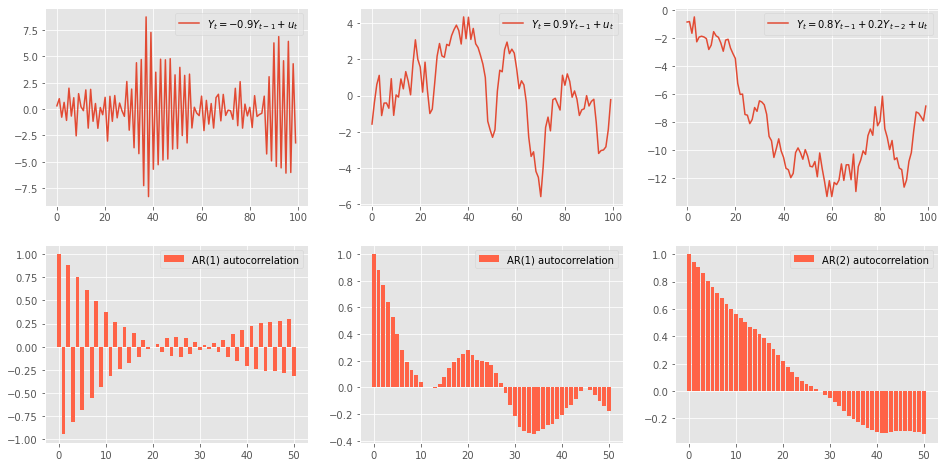

In [3]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)
ax[0, 0].plot(ar1_sim, label="$Y_t = {%s}Y_{t-1}+u_t$" % (-ar_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(
    np.arange(len(ar1_acf)), ar1_acf, color="tomato", label="AR(1) autocorrelation"
)
ax[1, 0].legend()

ax[0, 1].plot(ar1_sim_pos, label="$Y_t = {%s}Y_{t-1}+u_t$" % (-ar_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(
    np.arange(len(ar1_acf_pos)),
    ar1_acf_pos,
    color="tomato",
    label="AR(1) autocorrelation",
)
ax[1, 1].legend()

ax[0, 2].plot(
    ar2_sim,
    label="$Y_t = {%s} Y_{t-1}+{%s} Y_{t-2}+u_t$" % (-ar_params2[1], -ar_params2[2]),
)
ax[0, 2].legend()
ax[1, 2].bar(
    np.arange(len(ar2_acf)), ar2_acf, color="tomato", label="AR(2) autocorrelation"
)
ax[1, 2].legend()
plt.show()

## <font face="gotham" color="purple"> Mechanism of Simulation </font>

In [4]:
np.random.seed(123)
#
m = 50
N = 150
epsilon = np.random.normal(loc=0, scale=0.5, size=N + m)
#
temp = np.array(1 + epsilon[0], ndmin=1)
temp = np.append(temp, 1 + 0.8 * temp[0] + epsilon[1])

In [5]:
for j in range(2, N + m):
    Y_temp = 1 + 1.1 * temp[j - 1] - 0.2 * temp[j - 2] + epsilon[j]
    temp = np.append(temp, Y_temp)
#

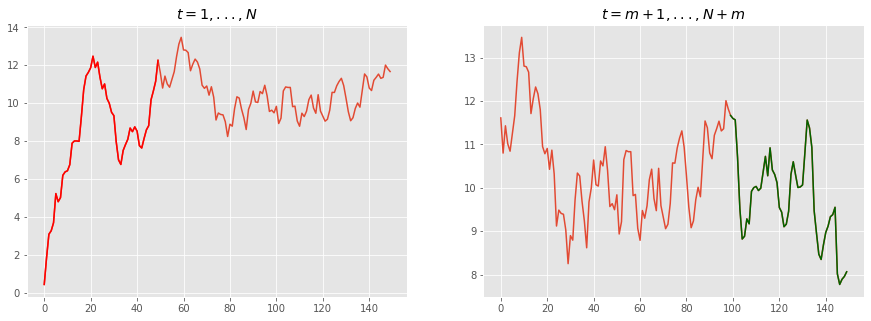

In [6]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
ax[0].plot(temp[:N])
ax[0].plot(list(range(0, m)), temp[:m], color="red")
ax[0].set_title("$t = 1, ..., N$")

ax[1].plot(temp[m:])
ax[1].plot(list(range(N - m - 1, N)), temp[(N - 1) :], color="darkgreen")
ax[1].set_title("$t = m + 1,..., N+m$")
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of AR(1)</font> 

The estimation can be achieved by instantiating an object from ```ARIMA``` class. As you can see the class requires specifying the order for $\text{ARIMA}$ model, where $\text{I}$ means integrated, i.e. order of difference to render stationary. 

For instance, $\text{AR(1)}$ with $1st$ order stationary series can also be written as $\text{ARIMA(1, 0, 0)}$.

Output ```sigma2``` is the variance of residuals $\sigma^2$. 

This is the model we are estimating
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$

In [7]:
mod_obj = ARIMA(ar1_sim_pos, order=(1, 0, 0))  # input the order for ARIMA
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(1)   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -140.456
Date:                Tue, 18 Oct 2022   AIC                            286.913
Time:                        08:43:05   BIC                            294.728
Sample:                             0   HQIC                           290.076
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1707      0.776      0.220      0.826      -1.350       1.692
ar.L1          0.8796      0.049     18.029      0.000       0.784       0.975
sigma2         0.9573      0.157      6.100      0.0

In [8]:
res_predict = result.predict(start=5, end=110)

Plot both the simulated $\text{AR(1)}$ and the forecast/predicted series.

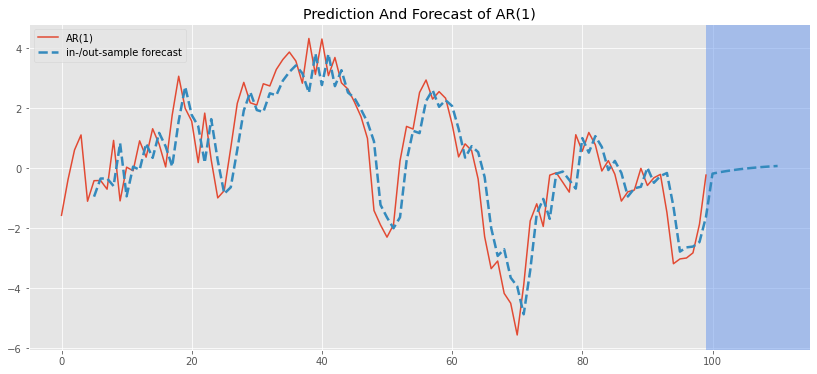

In [9]:
ar1_sim_pos.plot(figsize=(14, 6), label="simulated AR(1) series")
res_predict.plot(
    label="in-/out-sample forecast",
    title="Prediction And Forecast of AR(1)",
    ls="--",
    lw=2.5,
)
plt.axvspan(
    len(ar1_sim_pos) - 1, len(ar1_sim_pos) + 15, alpha=0.5, lw=0, color="CornflowerBlue"
)
plt.xlim([-5, 115])
plt.legend()
plt.show()

# <font face="gotham" color="purple">Identification of the Order of an AR Model </font>

The usual practice of order identification is called **the Box-Jenkins Methodology**, which will be explicated below, for now we simply perform two techniques:
1. Partial Autocorrelation Function
2. Akaike or Bayesian Information Criteria ($\text{AIC}$, $\text{BIC}$)

First, we will simulate a series, the true data generating process is given by $\text{AR(4)}$
$$
Y_{t}=-0.8 Y_{t-1}-0.2 Y_{t-2}+0.2Y_{t-3}+0.1Y_{t-4}+u_{t}
$$


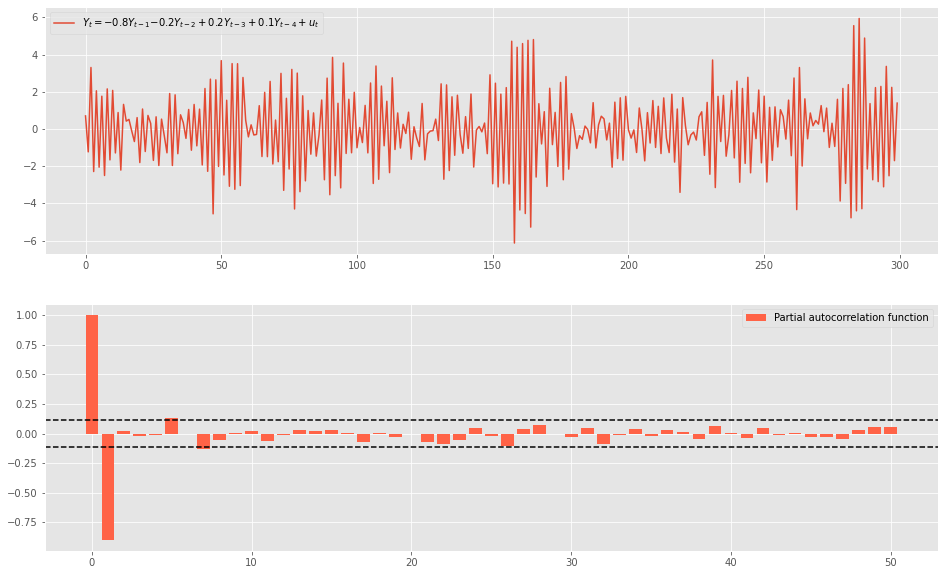

In [10]:
obs = 300

ar_params = np.array([1, 0.8, 0.2, -0.2, -0.1])
ma_params = np.array([1])
ar4 = ArmaProcess(ar_params, ma_params)
ar4_sim = ar1.generate_sample(nsample=obs)
ar4_sim = pd.DataFrame(ar4_sim, columns=["AR(4)"])
ar4_pacf = pacf_func(ar4_sim.values, nlags=50)

fig, ax = plt.subplots(figsize=(16, 10), nrows=2, ncols=1)
ax[0].plot(
    ar4_sim,
    label="$Y_t = {%s}Y_{t-1} {%s}Y_{t-2} +{%s}Y_{t-3} +{%s}Y_{t-4}+u_t$"
    % (-ar_params[1], -ar_params[2], -ar_params[3], -ar_params[4]),
)
ax[0].legend()
ax[1].bar(
    np.arange(len(ar4_pacf)),
    ar4_pacf,
    color="tomato",
    label="Partial autocorrelation function",
)
ax[1].axhline(y=2 / np.sqrt(obs), linestyle="--", color="k")
ax[1].axhline(y=-2 / np.sqrt(obs), linestyle="--", color="k")
ax[1].legend()
plt.show()

Only lag $1$ is significant in PACF, which suggests we could estimate the series with $\text{AR(1)}$. However, we could also identify the lags by using $\text{AIC}$ and $\text{BIC}$. 

The basic notion is to compare competing models and choose the one with lowest $\text{BIC}$ or $\text{AIC}$. You don't need to use both of them, I personally prefer to $\text{BIC}$.

In [11]:
aic, bic = [], []
max_lag = 20
for i in range(max_lag):  # compare max_lag lags
    mod_obj = ARIMA(ar4_sim, order=(i, 0, 0))
    result = mod_obj.fit()
    aic.append(result.aic)
    bic.append(result.bic)

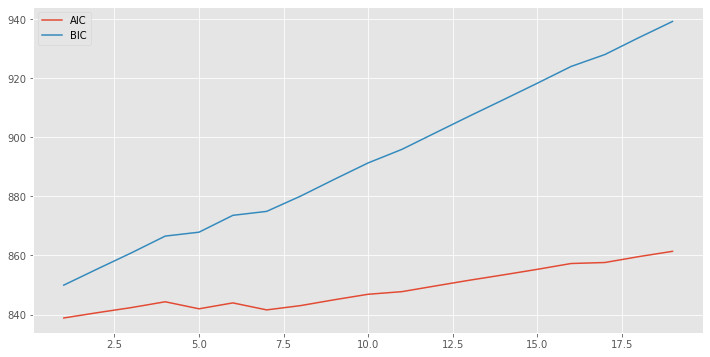

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, max_lag), aic[1:max_lag], label="AIC")
ax.plot(range(1, max_lag), bic[1:max_lag], label="BIC")
ax.legend()
plt.show()

In this case, an $\text{AR(1)}$ model would be fair good fit. Then we fit it.

In [13]:
mod_obj = ARIMA(ar4_sim, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(4)   No. Observations:                  300
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -416.415
Date:                Tue, 18 Oct 2022   AIC                            838.830
Time:                        08:43:15   BIC                            849.941
Sample:                             0   HQIC                           843.276
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0364      0.030     -1.226      0.220      -0.095       0.022
ar.L1         -0.8899      0.024    -36.820      0.000      -0.937      -0.843
sigma2         0.9352      0.080     11.636      0.0

# <font face="gotham" color="purple"> MA Model </font>

The _Moving Average_ model is the missing part of workhorse $\text{ARIMA}$. Here is an $\text{MA(1)}$ model
$$
Y_{t}= u_{t}+\theta_{1} u_{t-1}
$$
And the codes for generating $\text{MA}$ series are similar to $\text{AR}$. The plots are for your references.

In [14]:
ar_params = np.array([1])
ma_params = np.array([1, 0.9])
ma1 = ArmaProcess(ar_params, ma_params)
ma1_sim = ma1.generate_sample(nsample=100)
ma1_sim = pd.DataFrame(ma1_sim, columns=["MA(1)"])
ma1_acf = acf_func(ma1_sim.values, fft=False, nlags=50)

ar_params1 = np.array([1])
ma_params1 = np.array([1, -0.9])
ma1_neg = ArmaProcess(ar_params1, ma_params1)
ma1_sim_neg = ma1_neg.generate_sample(nsample=100)
ma1_sim_neg = pd.DataFrame(ma1_sim_neg, columns=["MA(1)"])
ma1_acf_neg = acf_func(ma1_sim_neg.values, fft=False, nlags=50)

ar_params2 = np.array([1])
ma_params2 = np.array([1, 0.8, 0.2])
ma2 = ArmaProcess(ar_params2, ma_params2)
ma2_sim = ma2.generate_sample(nsample=100)
ma2_sim = pd.DataFrame(ma2_sim, columns=["MA(2)"])
ma2_acf = acf_func(ma2_sim.values, fft=False, nlags=50)

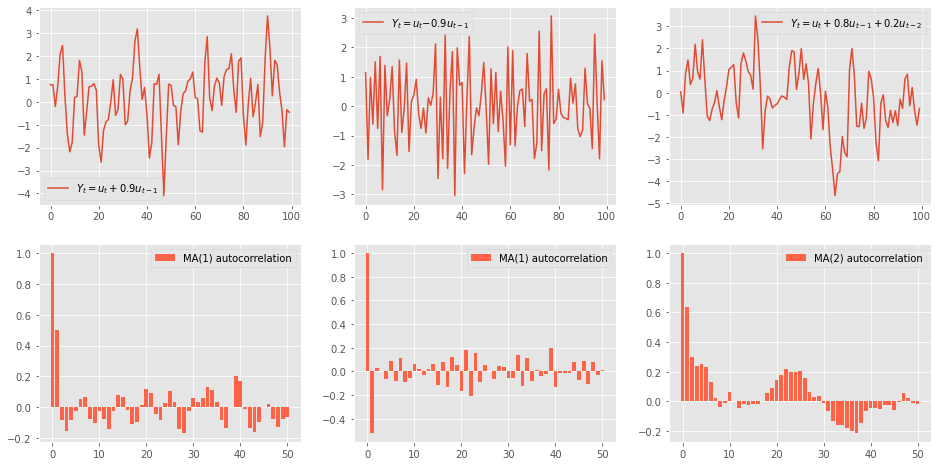

In [15]:
fig, ax = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)
ax[0, 0].plot(ma1_sim, label="$Y_t = u_t + {%s} u_{t-1}$" % (ma_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(
    np.arange(len(ma1_acf)), ma1_acf, color="tomato", label="MA(1) autocorrelation"
)
ax[1, 0].legend()

ax[0, 1].plot(ma1_sim_neg, label="$Y_t =  u_t  {%s} u_{t-1}$" % (ma_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(
    np.arange(len(ma1_acf_neg)),
    ma1_acf_neg,
    color="tomato",
    label="MA(1) autocorrelation",
)
ax[1, 1].legend()

ax[0, 2].plot(
    ma2_sim,
    label="$Y_t =  u_t   +{%s} u_{t-1}+ {%s} u_{t-2}  $"
    % (ma_params2[1], ma_params2[2]),
)
ax[0, 2].legend()
ax[1, 2].bar(
    np.arange(len(ma2_acf)), ma2_acf, color="tomato", label="MA(2) autocorrelation"
)
ax[1, 2].legend()
plt.show()

## <font face="gotham" color="purple">  Features of MA</font> 

An $\text{MA(1)}$ process with constant term $\mu$, takes the form
$$
Y_{t}=\mu + u_{t}+\theta u_{t-1},\qquad u_t\sim N(0, \sigma^2)
$$

Take expectation
$$
E(Y_{t})= E(\mu+u_{t}+\theta u_{t-1}) = E(\mu)+E(u_{t})+\theta E(u_{t-1}) = \mu
$$
The $\mu$ is the mean of $Y_t$.

If the MA process doesn't have a constant, the expectation will be $0$.

The variance of $\text{MA(1)}$
$$
\begin{aligned}
E\left(Y_t-\mu\right)^2 &=E\left(u_t+\theta u_{t-1}\right)^2 \\
&=E\left(u_t^2+2 \theta u_t u_{t-1}+\theta^2 u_{t-1}^2\right) \\
&=\sigma^2+0+\theta^2 \sigma^2 \\
&=\left(1+\theta^2\right) \sigma^2 
\end{aligned}
$$

Thus an $\text{MA(1)}$ process is always a (weak) stationary process.

Similarly, the general case of a $\text{MA}(q)$ process 
$$
Y_t=\mu+u_t+\theta_1 u_{t-1}+\theta_2 u_{t-2}+\cdots+\theta_q u_{t-q}
$$

The mean is given by
$$
E(Y_t)=E(\mu)+E(u_t)+\theta_1 E( u_{t-1})+\theta_2 E( u_{t-2})+\cdots+\theta_q E( u_{t-q})=\mu
$$
And the variance is given by
$$
E\left(Y_t-\mu\right)^2=E\left(u_t+\theta_1 u_{t-1}+\theta_2 u_{t-2}+\cdots+\theta_q u_{t-q}\right)^2
$$
Since $u$'s are uncorrelated, there won't be any cross terms in the variance
$$
E\left(Y_t-\mu\right)^2=\sigma^2+\theta_1^2 \sigma^2+\theta_2^2 \sigma^2+\cdots+\theta_q^2 \sigma^2=\left(1+\theta_1^2+\theta_2^2+\cdots+\theta_q^2\right) \sigma^2
$$
Thus an $\text{MA}(q)$ process is always a (weak) stationary process.

As for autocovariance $\gamma_k$
\begin{aligned}
\text{Cov}(Y_t , Y_{t-k})=\gamma_j=& E\left[\left(u_t+\theta_1 u_{t-1}+\theta_2 u_{t-2}+\cdots+\theta_q u_{t-q}\right)\right.\\
&\left.\times\left(u_{t-k}+\theta_1 u_{t-k-1}+\theta_2 u_{t-k-2}+\cdots+\theta_q u_{t-k-q}\right)\right] \\
=& E\left[\theta_k u_{t-k}^2+\theta_{k+1} \theta_1 u_{t-k-1}^2+\theta_{k+2} \theta_2 u_{t-k-2}^2+\cdots+\theta_q \theta_{q-k} u_{t-q}^2\right]
\end{aligned}
To summarize, 
$$
\gamma_j=\left\{\begin{array}{l}
{\left[\theta_k+\theta_{k+1} \theta_1+\theta_{k+2} \theta_2+\cdots+\theta_q \theta_{q-k}\right] \cdot \sigma^2}\qquad j=1,2,...,q \\
0\qquad j>q
\end{array}\right.
$$
which mean ACF of $\text{MA}(q)$ after $q$ lags is zero.

## <font face="gotham" color="purple">  Estimation and Forecast of MA</font> 

Estimate the series generated by true relationship
$$
Y_{t}= u_{t}-0.9 u_{t-1}
$$

In [16]:
mod_obj = ARIMA(ma1_sim_neg, order=(0, 0, 1))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA(1)   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -137.433
Date:                Tue, 18 Oct 2022   AIC                            280.866
Time:                        08:43:17   BIC                            288.682
Sample:                             0   HQIC                           284.029
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.008     -0.150      0.881      -0.017       0.014
ma.L1         -0.9331      0.048    -19.482      0.000      -1.027      -0.839
sigma2         0.8961      0.148      6.041      0.0

In [17]:
res_predict = result.predict(start=5, end=110)

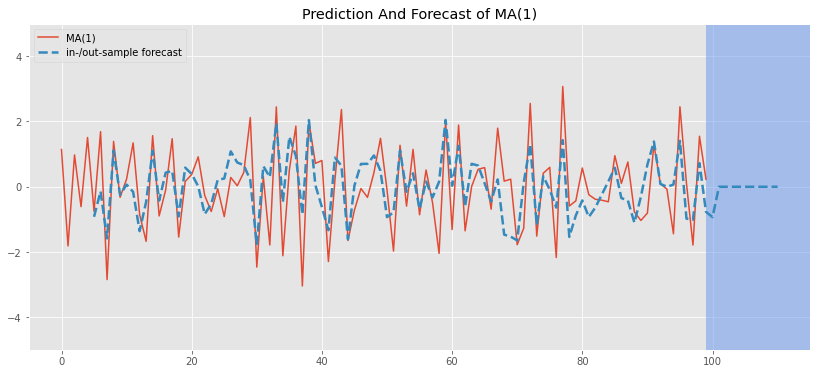

In [18]:
ma1_sim_neg.plot(figsize=(14, 6))
res_predict.plot(
    label="in-/out-sample forecast",
    title="Prediction And Forecast of MA(1)",
    ls="--",
    lw=2.5,
)
plt.axvspan(
    len(ar1_sim_pos) - 1, len(ar1_sim_pos) + 15, alpha=0.5, lw=0, color="CornflowerBlue"
)
plt.xlim([-5, 115])
plt.ylim([-5, 5])
plt.legend()
plt.show()

Note that all forecasts beyond one-step ahead forecast will all be the identical, namely a straight line in the blue shaded area.

# <font face="gotham" color="purple"> Connections of AR and MA </font>

We can show that any $\text{AR(1)}$ can be rewritten as an $\text{MA($\infty$)}$ model
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
Perform a recursive substitution
\begin{align}
Y_t &= \phi_0 + \phi_1(\phi_0 + \phi_1Y_{t-2}+u_{t-1})+u_t = \phi_0 + \phi_1\phi_0+\phi_1^2Y_{t-2}+\phi_1u_{t-1}+u_t\\
    &= \phi_0 + \phi_1\phi_0+\phi_1^2(\phi_0+\phi_1Y_{t-3}+u_{t-2})+\phi_1u_{t-1}+u_t=\phi_0 + \phi_1\phi_0 +\phi_1^2\phi_0 +\phi_1^3Y_{t-3}+\phi_1^2u_{t-2}+\phi_1u_{t-1}+u_t\\
    &\qquad\vdots\\
    &=\frac{\phi_0}{1-\phi_1}+\sum_{i=0}^\infty\phi_1^iu_{t-1}
\end{align}
It holds because of the fact
$$
\lim_{i\rightarrow\infty}\phi_1^iY_{t-i}=0, \qquad-1<\phi <1
$$

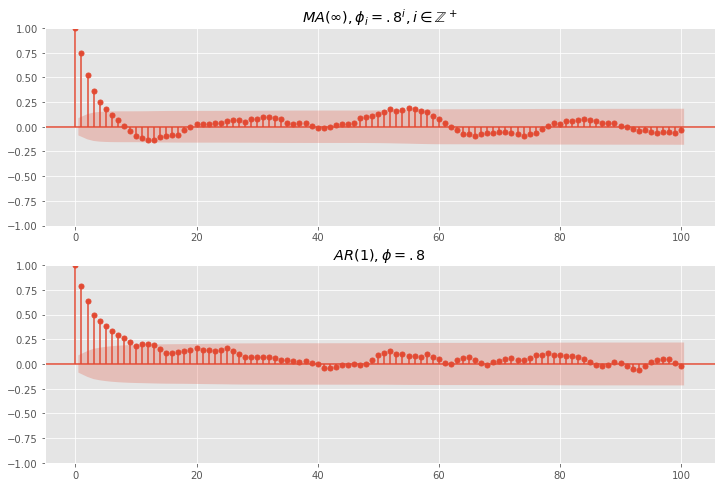

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
ar = np.array([1])
ma = np.array([0.8**i for i in range(100)])
mod_obj = ArmaProcess(ar, ma)
ma_sim = mod_obj.generate_sample(nsample=500)
g = plot_acf(
    ma_sim, ax=ax[0], lags=100, title="$MA(\infty), \phi_i = .8^i, i\in \mathbb{Z}^+$"
)

ar = np.array([1, -0.8])
ma = np.array([1])
mod_obj = ArmaProcess(ar, ma)
ar_sim = mod_obj.generate_sample(nsample=500)
g = plot_acf(ar_sim, ax=ax[1], lags=100, title="$AR(1), \phi=.8$")

## <font face="gotham" color="purple"> ACF vs PACF </font>

Before the discussion of $\text{ARIMA}$ identification, we shall make some sense out of **autocorrelation function** (ACF) and **partial autocorrelation function** (PACF), which both are classical tools for identifying lags of $\text{ARIMA}$.

We have shown that the formula of sample ACF
$$
\rho_{k}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\sqrt{\operatorname{Var}\left(r_{t}\right) \operatorname{Var}\left(r_{t-k}\right)}}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\operatorname{Var}\left(r_{t}\right)}=\frac{\gamma_{k}}{\gamma_{0}}
$$

However, PACF doesn't have a formula. 

Simply speaking, PACF requires removing all correlations in between. e.g. if you are measuring autocorrelation $k$ periods apart, then all influences within the $k$ should be eliminated.

One common way of evaluating PACF is to use demeaned regression
$$
y_t-\bar{y}=\phi_{11} (y_{t-1}-\bar{y})+\phi_{22} (y_{t-2}-\bar{y})+\phi_{33} (y_{t-3}-\bar{y})+u_{t}
$$
Estimates of $\phi_{kk}$ is the partial correlation at lag $3$.

Partial autocorrelation function (PACF) is used for choosing the order of $\text{AR}$ models, in contrast, ACF is for $\text{MA}$ models.

# <font face="gotham" color="purple"> ARMA and ARIMA </font>

Finally, we join $\text{AR}$ and $\text{MA}$ models as $\text{ARMA}$ or $\text{ARMIA}$.

An $\text{ARMA}(1,1)$ process is a straightforward combination of $\text{AR}$ and $\text{MA}$:
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+\theta_{0} u_{t}+\theta_{1} u_{t-1}
$$

In general, $\text{ARMA}(p,q)$ process has the form
$$
Y_t = \phi_0 + \sum_{i=1}^p \phi_i Y_{t-i}+\sum_{i=1}^q\theta_i u_{t-i} \tag{2}\label{2}
$$

In lag operator form
$$
\begin{aligned}
\left(1-\phi_1 L-\phi_2 L^2-\cdots\right.&\left.-\phi_p L^p\right) Y_t=\phi_0+\left(1+\theta_1 L+\theta_2 L^2+\cdots+\theta_q L^q\right) u_t .
\end{aligned}
$$

The lag operator form's sign is the one that ```statsmodels``` using, i.e. reversing the signs of all $\text{AR}$ terms.

And $\text{ARIMA}$ model is essentially the same as $\text{ARMA}$, it mean we have to difference a series $d$ times to render it stationary before applying an $\text{ARIMA}$ model, we say that the original time series is $\text{ARIMA}(p,d,q)$ process. 

By the same token, $\text{ARIMA}(p,0,q)$ process is exactly the same as $\text{ARMA}(p,q)$.

## <font face="gotham" color="purple"> Features of ARMA </font>

Take expectation of $(2)$
$$
\begin{align}
E(Y_t) &= E(\phi_0) + \sum_{i=1}^p \phi_i E(Y_{t-i})+\sum_{i=1}^q\theta_i E(u_{t-i} )\\
\mu &= \phi_0 + \sum_{i=1}^p \phi_i \mu \qquad\longrightarrow \qquad \mu=\frac{\phi_0}{1- \sum_{i=1}^p \phi_i}
\end{align}
$$

which means stationarity of $\text{ARMA}$ completely depends the parameters of $\text{AR}$.

The demeaned form can lead us to autocovariance as shown previously

$$
\begin{aligned}
Y_t-\mu=& \phi_1\left(Y_{t-1}-\mu\right)+\phi_2\left(Y_{t-2}-\mu\right)+\phi_p\left(Y_{t-p}-\mu\right)+\varepsilon_t+\theta_1 \varepsilon_{t-1}+\theta_2 \varepsilon_{t-2}+\cdots+\theta_q \varepsilon_{t-q} .
\end{aligned}
$$

Multiply both sides by $(Y_{t-j}-\mu)$ and take expectation, resulting equation takes the form
$$
\gamma_j=\phi_1 \gamma_{j-1}+\phi_2 \gamma_{j-2}+\cdots+\phi_p \gamma_{j-p} \quad \text { for } j=q+1, q+2, \ldots
$$

which means after lag $q$, the autocovariance/autocorrelation function follows the $p$th order difference equation by the autoregressive parameters.

## <font face="gotham" color="purple"> Box-Jenkins Methodology </font>

The pipeline of working through an $\text{ARIMA}$ model from identification to forecasting is called **Box-Jenkins Methodology** which includes _identification, estimation, diagnostics_ and _forecasting_.

As an example, let's import an series from Fred. Needless to say it's unstationary at first sight.

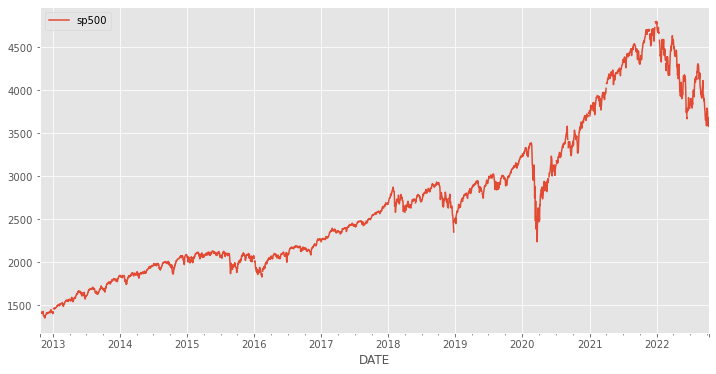

In [20]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime.today()  # the last time I run this file is in Oct 2022
df = data.DataReader(["sp500"], "fred", start, end)
df.plot(figsize=(12, 6))
plt.show()

As we have discussed, there are several methods to stationarize a series: log difference, percentage change and simple difference.

And remember that Box-Jenkins methodology requires stationary time series.

In [21]:
df["sp500_ln_diff"] = np.log(df) - np.log(df.shift())  # log differencea
df["sp500_pct"] = df["sp500"].pct_change()  # percentage change
df["sp500_diff"] = df["sp500"].diff()  # simply 1st order difference
df = df.dropna()

The series with each method are plotted below, the third one, i.e. simple difference, shows heteroskedasticity to some extent in later period, financial series with simple difference commonly shows this feature, which is also the reason we rarely use simple difference on financial series. 

The first two are similar, you choose anyone you see fit. However the industrial standard is log difference for its mathematical flexibility.

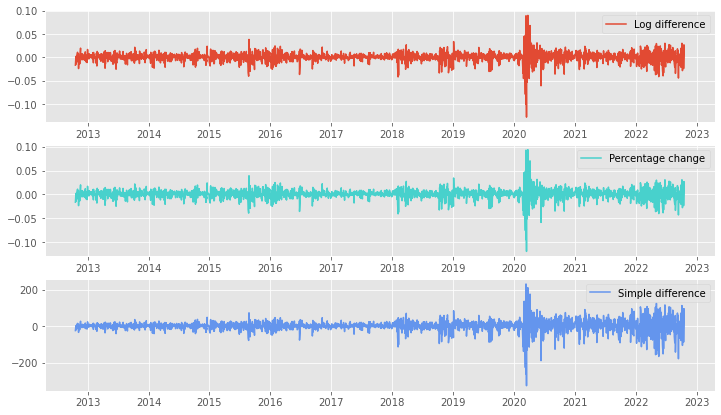

In [22]:
fig, ax = plt.subplots(figsize=(12, 7), nrows=3, ncols=1)
ax[0].plot(df["sp500_ln_diff"], label="Log difference")
ax[0].legend()

ax[1].plot(df["sp500_pct"], label="Percentage change", color="MediumTurquoise")
ax[1].legend()

ax[2].plot(df["sp500_diff"], label="Simple difference", color="CornflowerBlue")
ax[2].legend()

plt.show()

Here is a technical issue highlighted, note below that ```freq=None```, this could cause an error in the ```ARIMA``` instantiation.

In [23]:
df.index

DatetimeIndex(['2012-10-19', '2012-10-22', '2012-10-23', '2012-10-24',
               '2012-10-25', '2012-10-26', '2012-11-01', '2012-11-02',
               '2012-11-05', '2012-11-06',
               ...
               '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
               '2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13',
               '2022-10-14', '2022-10-17'],
              dtype='datetime64[ns]', name='DATE', length=2422, freq=None)

The solution is to explicitly define it as days ```D```.

In [24]:
df.index = pd.DatetimeIndex(df.index).to_period("D")

Now the index is explicitly labeled as days. 

Also divide them into training and test sets.

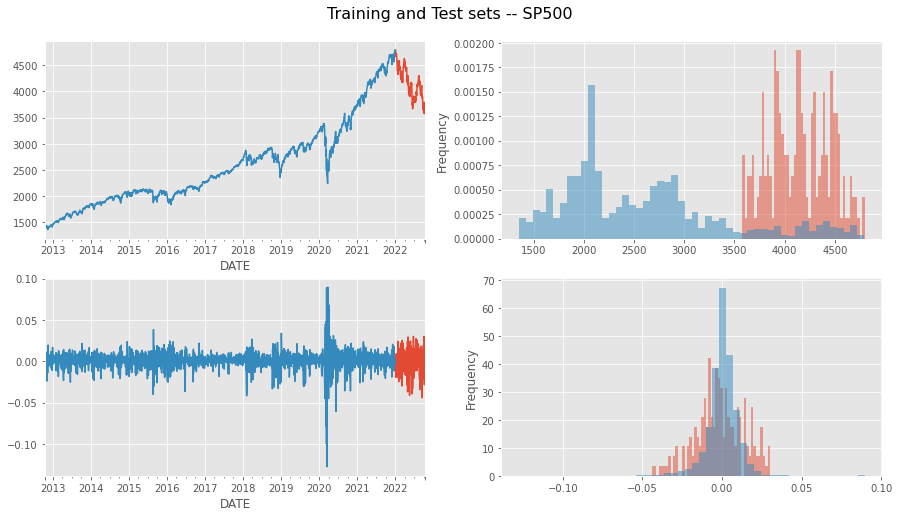

In [25]:
df_train = df.loc[:"2021"]
df_test = df.loc["2022":]

fig, ax = plt.subplots(figsize=(15, 8), nrows=2, ncols=2)

df_test["sp500"].plot(ax=ax[0, 0])
df_train["sp500"].plot(ax=ax[0, 0])
df_test["sp500"].plot.hist(ax=ax[0, 1], bins=50, alpha=0.5, density=True)
df_train["sp500"].plot.hist(ax=ax[0, 1], bins=50, alpha=0.5, density=True)

df_test["sp500_ln_diff"].plot(ax=ax[1, 0])
df_train["sp500_ln_diff"].plot(ax=ax[1, 0])
df_test["sp500_ln_diff"].plot.hist(ax=ax[1, 1], bins=50, alpha=0.5, density=True)
df_train["sp500_ln_diff"].plot.hist(ax=ax[1, 1], bins=50, alpha=0.5, density=True)
plt.suptitle("Training and Test sets -- SP500", size=16, y=0.94)
plt.show()

## <font face="gotham" color="purple"> Identification </font>

Correlograms of ACF and PACF are shown as below.

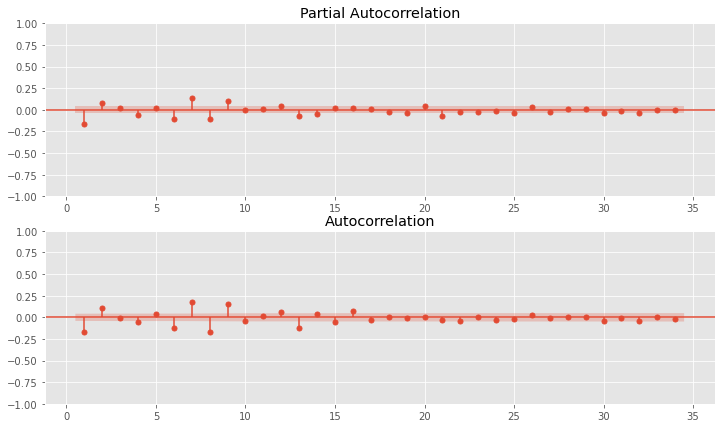

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 7))
g1 = plot_pacf(df_train["sp500_ln_diff"], ax=ax[0], method="ywm", zero=False)
g2 = plot_acf(df_train["sp500_ln_diff"], ax=ax[1], zero=False)

As identification shows, it actually suggests 2nd orders for both $\text{AR}$ and $\text{MA}$.

## <font face="gotham" color="purple"> Estimation </font>

Of course you can use ```statsmodels``` to estimate the model with the orders suggested by correlograms, another option is ```pmdarima``` library, it automatically performs a grid search of $\text{ARIMA}$ orders.

You can specify the $p$, $d$ and $q$ for $\text{ARIMA}$, or give a range, or even left them out to default values. If anything unclear, run ```pm.auto_arima?```.

In [27]:
results1 = pm.auto_arima(
    df_train["sp500_ln_diff"],
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    trace=True,
    information_criterion="bic",  # default is AIC
    error_action="ignore",  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True,
)  # set to stepwise

Performing stepwise search to minimize bic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-14019.668, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-13963.935, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-14018.944, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-14008.914, Time=1.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-13966.736, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-14018.343, Time=0.97 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-14019.958, Time=0.74 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-14028.083, Time=0.80 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : BIC=-14021.712, Time=1.50 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : BIC=-14013.758, Time=2.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : BIC=-14030.517, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0]             : BIC=-14009.240, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : BIC=-14022.132, Time=0.84 sec
 ARIMA(0,0,3)(0,0,0)[0]             : BIC=-14020.894, Time=0.32 sec
 ARIM

However $\text{BIC}$ suggests order $(0, 0, 2)$. To print the estimation results, use the ```summary()``` method.

In [28]:
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2230
Model:               SARIMAX(0, 0, 2)   Log Likelihood                7026.823
Date:                Tue, 18 Oct 2022   AIC                         -14047.646
Time:                        08:43:35   BIC                         -14030.517
Sample:                    10-19-2012   HQIC                        -14041.392
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1478      0.008    -19.381      0.000      -0.163      -0.133
ma.L2          0.1175      0.007     17.353      0.000       0.104       0.131
sigma2         0.0001   1.08e-06     99.729      0.0

However, if you believe you can find a better order, feel free to use ```ARIMA``` class directly.

Instantiate a $\text{ARIMA}$ object with order $(3, 0, 2)$.

In [29]:
mod_obj_2 = ARIMA(df_train["sp500_ln_diff"], order=(3, 0, 2))
results2 = mod_obj_2.fit()
print(results2.summary())

                               SARIMAX Results                                
Dep. Variable:          sp500_ln_diff   No. Observations:                 2230
Model:                 ARIMA(3, 0, 2)   Log Likelihood                7048.803
Date:                Tue, 18 Oct 2022   AIC                         -14083.605
Time:                        08:43:38   BIC                         -14043.637
Sample:                    10-19-2012   HQIC                        -14069.010
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.926      0.054   -8.54e-06       0.001
ar.L1         -0.7698      0.067    -11.543      0.000      -0.900      -0.639
ar.L2          0.1882      0.068      2.748      0.0

Almost all p-values shows the significance, therefore it could be an alternative model to the previous one.

## <font face="gotham" color="purple"> Diagnostics of Residuals </font>

All you need to care is that whether the residuals are generated from an white noise stochastic process.

In [44]:
def resid_diagnostics(resid):
    fig, ax = plt.subplots(figsize=(16, 4), nrows=1, ncols=3)
    resid.plot(ax=ax[0], title="Resid plot", color="MediumTurquoise")
    resid.plot.hist(ax=ax[1], density=True, bins=100, color="Brown")
    resid.plot.kde(ax=ax[1], alpha=0.8, color="red", title="Distribution of resid")
    g = plot_acf(
        resid,
        ax=ax[2],
        lags=50,
        title="Correlogram of resid",
        zero=False,
        color="CornflowerBlue",
    )
    plt.show()

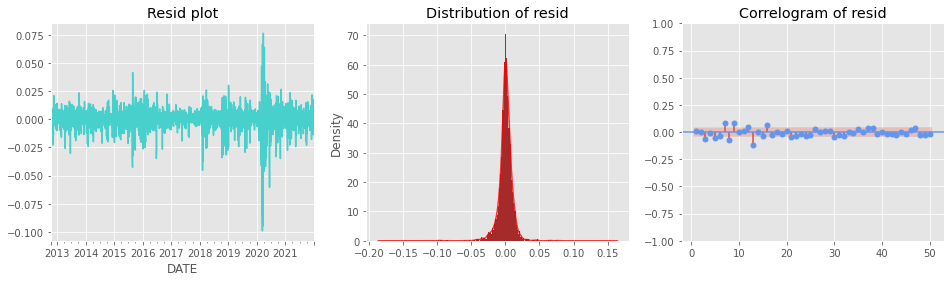

In [45]:
resid = results2.resid
resid_diagnostics(resid)

You can use the stylized residual diagnostics from ```statsmodels```, a bit overkill though.

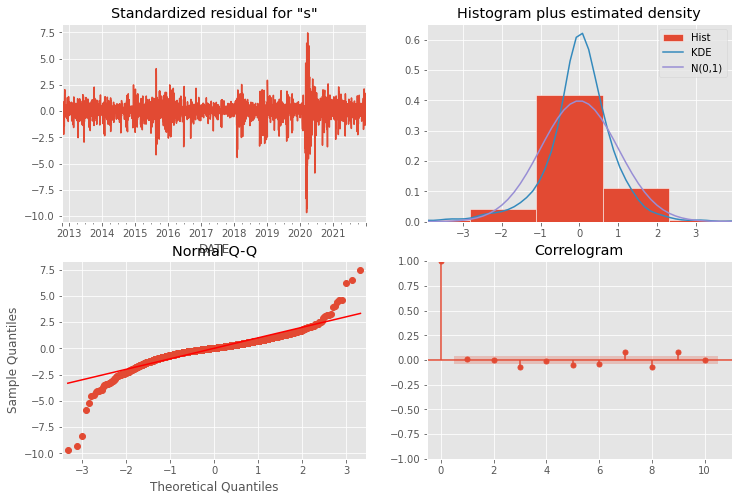

In [41]:
g = results2.plot_diagnostics(figsize=(12, 8))

Not perfectly white noise, but we can live with that.

## <font face="gotham" color="purple"> Forecasting </font>

We have estimated the model with log difference, naturally the forecasts will also be log difference, however this confuses layman audiences. To obtain the level of forecasting values, we integrate the first log difference, then take exponential. 

In [84]:
results2.forecast(500)

2018-11-27    0.001716
2018-11-28   -0.001100
2018-11-29    0.001415
2018-11-30   -0.000314
2018-12-01    0.001013
                ...   
2020-04-05    0.000490
2020-04-06    0.000490
2020-04-07    0.000490
2020-04-08    0.000490
2020-04-09    0.000490
Freq: D, Name: predicted_mean, Length: 500, dtype: float64

In [70]:
df_test.index[0]

Period('2022-01-03', 'D')

In [77]:
predi = results2.get_prediction(
    start=df_test.index[0], end=df_test.index[-1], dynamic=True
)

In [79]:
predi.predicted_mean

2022-01-03    0.00049
2022-01-04    0.00049
2022-01-05    0.00049
2022-01-06    0.00049
2022-01-07    0.00049
               ...   
2022-10-13    0.00049
2022-10-14    0.00049
2022-10-15    0.00049
2022-10-16    0.00049
2022-10-17    0.00049
Freq: D, Name: predicted_mean, Length: 288, dtype: float64

In [78]:
predi

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_df',
 '_predicted_mean',
 '_row_labels',
 '_use_pandas',
 '_var_pred_mean',
 '_wrap_pandas',
 'conf_int',
 'dist',
 'dist_args',
 'model',
 'predicted_mean',
 'prediction_results',
 'row_labels',
 'se_mean',
 'summary_frame',
 't_test',
 'tvalues',
 'var_pred_mean']

In [75]:
results2.get_prediction()

In [36]:
dir(results2)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_robustcov_results',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_exog',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_params_variance',
 '_rank',
 '_states',
 '_use_t',
 

In [32]:
mod_obj = pm.auto_arima(
    df_train["LULU"],
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    trace=True,
    information_criterion="bic",  # default is AIC
    error_action="ignore",  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True,
)  # set to stepwise

KeyError: 'LULU'

In [ ]:
arima_obj = ARIMA(df_train["LULU"], order=(2, 1, 2))
arima_results = arima_obj.fit()

In [ ]:
step = 100
fc = arima_results.forecast(100)  # out of sample forecasts

In [ ]:
df["forecast"] = pd.DataFrame([None] * len(df_train) + list(fc))

In [ ]:
fig, ax = plt.subplots()
df_test["LULU"].plot()
df_train["LULU"].plot()
df["forecast"].plot()

In [ ]:
g = tsa.plot_predict(
    arima_results, start="2020-01-03", end="2023-01-01", alpha=0.05, dynamic=True
)
df_train["LULU"].plot(figsize=(18, 6))
plt.show()

In [ ]:
test_size = len(df_test["LULU"])
prediction, conf_int = mod_obj.predict(n_periods=test_size, return_conf_int=True)

In [ ]:
mod_obj = ARIMA(df_train["LULU_ln_diff"], order=(1, 0, 0))

In [ ]:
results = mod_obj.fit()

In [ ]:
print(results.summary())

In [ ]:
insample_pred = results.get_prediction(start=-50)

In [ ]:
mean_insample_pred = insample_pred.predicted_mean
confi_int = insample_pred.conf_int()

In [ ]:
fig, ax = plt.subplots()
mean_insample_pred.plot(ax=ax)
confi_int.plot(ax=ax)
plt.show()

In [ ]:
g = tsa.plot_predict(
    results, start="2020-01-03", end="2023-01-01", alpha=0.05, dynamic=False
)
df_train["LULU_ln_diff"].plot(figsize=(18, 6))
plt.show()

It's actually quite pointless to estimate an $\text{ARIMA}$ model as this example, it almost have no forecast power.

# <font face="gotham" color="purple"> ARMAX Models</font>

In [ ]:
start = dt.datetime(2015, 1, 1)
end = dt.datetime.today()
TSLA = data.DataReader(["TSLA"], "yahoo", start, end)[
    "Close"
]  # pick adj close price of Lululemon
sp500 = data.DataReader(["SP500"], "fred", start, end).dropna()

In [ ]:
mod_obj = pm.auto_arima(
    sp500,
    start_p=1,
    start_q=1,
    max_p=5,
    max_q=5,
    trace=True,
    information_criterion="bic",  # default is AIC
    error_action="ignore",  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True,
)  # set to stepwise